<a href="https://colab.research.google.com/github/aero-surge/Regression/blob/main/DNN_Regression_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Regression using TensorFlow**

---
In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability

regression is used to predict the value of a variable based on the value of another variable. The variable you want to predict is called the dependent variable. The variable you are using to predict the other variable's value is called the independent variable.

---

In [1]:
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt   # Importing matplotlib which will help us in data visualization
import numpy as np                # numpy is a Numerical programming package for the Python and will help us with large array vectors
import pandas as pd               # pandas is a Python library for data manipulation and analysis
import seaborn as sns             # Seaborn is a Python data visualization library based on matplotlib

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf         #Machine learning software library

from tensorflow import keras   # Keras Neural network library
from tensorflow.keras import layers

print(tf.__version__)         # It is important to note the TF Verson for compatibility issues

2.8.2


##Importing the Datset


In [58]:
#importing the dataset directly from cloud 
#url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

csv = '/content/auto-mpg.csv' # importing the file locally
raw_dataset = pd.read_csv(csv,na_values='?')

In [59]:
dataset = raw_dataset.copy()
dataset.tail()
# all of our vehicle attributes can be seen here that we will be using to find the milage

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1
397,31.0,4,119.0,82.0,2720,19.4,82,1


##Filtering the data

In [60]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [61]:
dataset = dataset.dropna()

Lets drop the origin as this is categorical not numeric. after this the orgin will be placed into 3 different columns Europe, Japan and USA

In [62]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720,19.4,82,0,0,1


##Splitting the data into Test and Train Split


---



we will split the dataset where one part is used to build the model and the rest to test it. 

In [63]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

##Visualizing the data

---

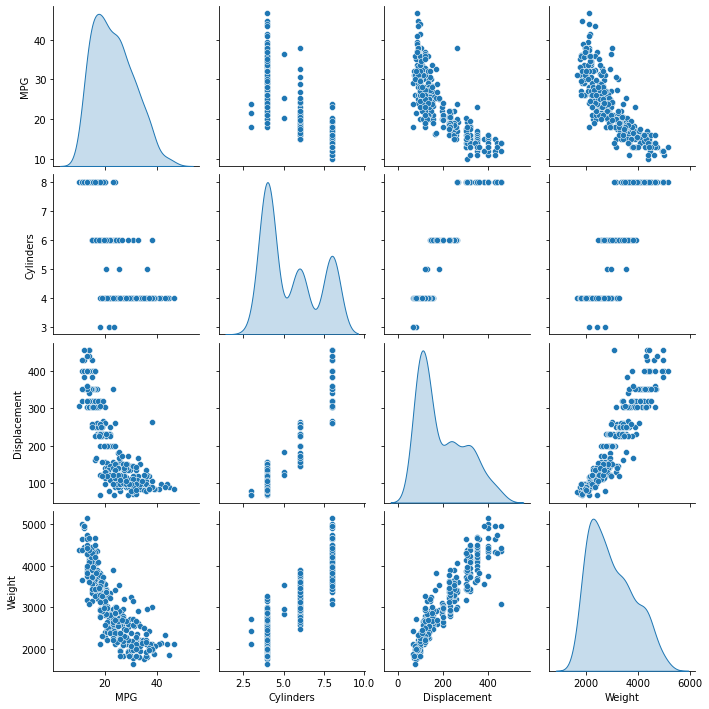

In [64]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [65]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [66]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

##Normalization

---


 reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

In [67]:
train_dataset.describe().transpose()[['mean', 'std']] # Normalization

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [68]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [69]:
normalizer.adapt(np.array(train_features))

In [70]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [71]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


##Regression with multiple inputs 

In [72]:
model_dnn = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [73]:
model_dnn.predict(train_features[:10])

array([[ 0.588],
       [ 0.704],
       [-1.627],
       [-0.085],
       [ 0.758],
       [-0.243],
       [ 1.002],
       [ 2.119],
       [-0.009],
       [ 1.694]], dtype=float32)

In [74]:
model_dnn.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.67 ],
       [-0.085],
       [ 0.348],
       [-0.39 ],
       [ 0.766],
       [-0.278],
       [ 0.125],
       [-0.215],
       [-0.141]], dtype=float32)>



---


configuring the model with keras ***Model.compile*** and ***Model.fit*** for 100 epochs 


---



In [75]:
model_dnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [76]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [77]:
%%time
history = model_dnn.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.43 s, sys: 218 ms, total: 4.64 s
Wall time: 5.67 s


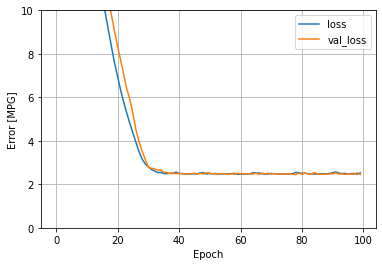

In [78]:
plot_loss(history)

##Regression with a deep neural network (DNN)

In [79]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'), # here we use Relu(rectified linear unit) activation finction
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001)) #Optimizer that implements the Adam algorithm.
  return model

In [80]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                640       
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


## Training the model with Keras ***Model.fit***



In [81]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.7 s, sys: 225 ms, total: 4.92 s
Wall time: 5.6 s


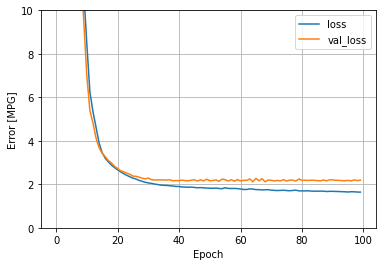

In [82]:
plot_loss(history)

In [91]:

test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
dnn_model,1.707148


##**Make Predictions**

---



we can now make predictions with the dnn_model on the test set using ***Model.predict***

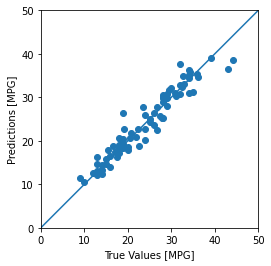

In [92]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


##Checking the Error Distribution

---



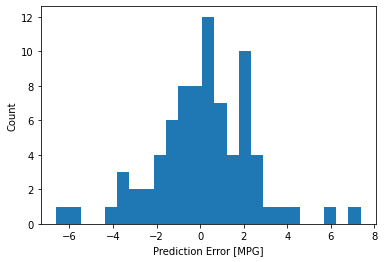

In [93]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

##Saving the model

---



In [94]:
dnn_model.save('dnn_model') # saving the TF model for later use

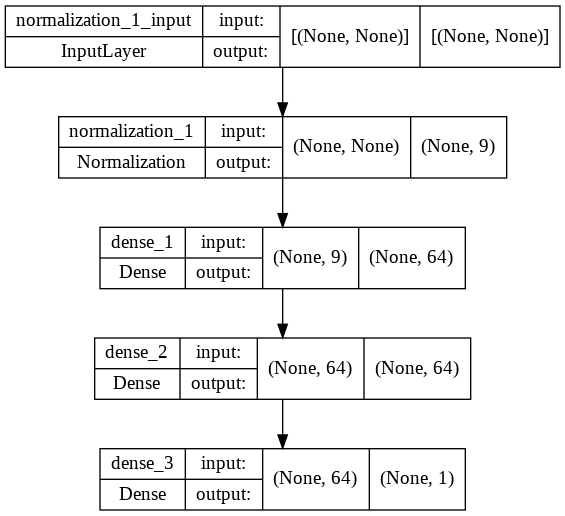

In [95]:
dot_img_file = '/content/model_1.png' #saving the NN representation image locally
tf.keras.utils.plot_model(dnn_model, to_file=dot_img_file, show_shapes=True)